# Capstone Project 
--------
Topic: Home contents insurance

Student Name: Victor Acosta

Student ID: 534

Training data: https://www.kaggle.com/datasets/xavierdataset/stable-home-insurance-data-driven-growth

### Overview

This document is divided into steps, following all the lifecycle stages of a ML project learned at the beginning of the course

__Business case__: Pattern-matching risk analysis on new contents insurance policies.<br />
__Input__: customer details, property details and geolocation details<br />
__Output__: High, Moderate or Low risk<br />


### Step 1.  Who is in the project?

As this is a unreal situation, just myself. In the hypothetical situtation of going live to production: developers/data engineers, MLOps, underwriters and product managers


### Step 2. Obtain the data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime  
from dateutil.parser import parse
import math 
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_datafile = "data/home_insurance.csv"

# Columns mapped one to one from the datasource (just the columns relevant to this business case)
columns = [ "P1_EMP_STATUS",     #Customer profesional status
            "BUS_USE",           #Policy for Business 
            "RISK_RATED_AREA_C", #Geographical classificaton of Risk personal objects            
            "CONTENTS_COVER",    #Coverage for personal items indicator
            "SPEC_ITEM_PREM",    #Premium personal items   
            "P1_MAR_STATUS",     #Marital status
            "P1_SEX",            #Gender 
            "P1_DOB",            #Date of birth 
            "P1_POLICY_REFUSED", #Policy refused
            "APPR_ALARM",        #Appropriate alarm
            "APPR_LOCKS",        #Appropiate locks
            "BEDROOMS", 
            "WALL_CONSTRUCTION", 
            "NEIGH_WATCH",
            "OCC_STATUS",        #Occupancy status
            "OWNERSHIP_TYPE",    #Type of ownership
            "PAYING_GUESTS",     #Tenants in the property
            "PROP_TYPE", 
            "SAFE_INSTALLED",
            "YEARBUILT", 
            "LEGAL_ADDON_PRE_REN",    #Legal fees included
            "HOME_EM_ADDON_PRE_REN",  #Emergencies option included
            "KEYCARE_ADDON_PRE_REN",  #Replacement of keys included
            "FLOODING",               #Flooding risk 
            "SUBSIDENCE",             #Subsidence risk 
            "LISTED",                 #Listed as protected property
            "SUM_INSURED_CONTENTS",   #Premium
            "CLAIM3YEARS"]

# Better naming for the above columns
features = ["EMPLOYMENT",     #R = Retired,E = Employed,N = Not Available,H = House person,S = Student ,U = Unemployed.
            "BUS_USE",         
            "RISK_RATED_AREA_C", 
            "CONTENTS_COVER",   
            "SPEC_ITEM_PREM",   
            "MAR_STATUS",     #M: Married, P: Partnered, O: Other, W: Widowed,S: Single,D: Divorced,A: Annulled,C: Common-law,B: Betrothed, N: Never Married
            "SEX",            
            "DOB",            
            "POLICY_REFUSED",
            "ALARM",       
            "LOCKS",       
            "BEDROOMS", 
            "WALL_CONSTRUCTION", 
            "NEIGH_WATCH",
            "OCCUPANCY",  # 'PH': 'Policy Holder's Residence', 'LP': 'Leaseholder Property', 'HH': 'Holiday Home', 'UN': 'Unoccupied', 'WD': 'Weekday Home', 'WE': 'Weekend Home', 'OT': 'Other'
            "OWNERSHIP_TYPE",
            "PAYING_GUESTS", 
            "PROP_TYPE", 
            "SAFE_INSTALLED",
            "YEARBUILT", 
            "LEGALFEES_COVER", 
            "EMERGENCIES_COVER", 
            "KEYREPLACE_COVER", 
            "FLOODING_RISK",    
            "SUBSIDENCE_RISK",  
            "LISTED",   # 1.0 to 5.0        
            "SUM_INSURED", 
            "CLAIM3YEARS"] 


dataset = pd.read_csv(train_datafile)
dataset.columns = dataset.columns.str.strip()
dataset = dataset[columns]

rename_dict = dict(zip(columns, features))
dataset = dataset.rename(columns=rename_dict)

#dataset.head(10)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.large_repr', 'truncate')
dataset.info(verbose=True)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256136 entries, 0 to 256135
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         189021 non-null  object 
 1   BUS_USE            189021 non-null  object 
 2   RISK_RATED_AREA_C  180290 non-null  float64
 3   CONTENTS_COVER     189021 non-null  object 
 4   SPEC_ITEM_PREM     189021 non-null  float64
 5   MAR_STATUS         189021 non-null  object 
 6   SEX                189021 non-null  object 
 7   DOB                189021 non-null  object 
 8   POLICY_REFUSED     189021 non-null  object 
 9   ALARM              189021 non-null  object 
 10  LOCKS              189021 non-null  object 
 11  BEDROOMS           189021 non-null  float64
 12  WALL_CONSTRUCTION  189021 non-null  float64
 13  NEIGH_WATCH        189021 non-null  object 
 14  OCCUPANCY          189021 non-null  object 
 15  OWNERSHIP_TYPE     189021 non-null  float64
 16  PA

In [2]:

# HELPER FUNCTIONS (FEEL FREE TO SKIP THIS BLOCK)

def calculate_risk(value, maximum = 100):
    one_third = maximum / 3
    if (value < one_third):
        return 1
    if (value < one_third * 2):
        return 2
    return 3

def decade(value):
    # Returns the decade of a year:  24 => 20, 1978 => 1970
    return value - (value % 10)

def age_group(value):
    # Returns the age group 20s, 30s, 40s, etc 
    delta = datetime.now() - value 
    years = math.floor(delta.days /365)
    return decade(years)

def get_value_counts(df):
    for col in df.columns:
        vc = df[col].value_counts(dropna=False)
        print(vc)    
        
def remove_outlier(value, values: list, fallback_value):
    # The rare values not in the list will be returned as fallback_value
    #3.0    98851       3.0    98851
    #2.0    52971   =>  2.0    52971
    #4.0    23994       4.0    23994
    #1.0     9806       1.0     9806
    #5.0     3264      -1.0     3399 
    #6.0      118       
    #7.0       17           
    if value in values:
        return value
    return fallback_value

#get_value_counts(dataset[['CLAIM3YEARS', 'BEDROOMS']])

def metrics(cm): #this function returns relevant statistics
    total = cm[0][0] + cm[1][1] +  cm[0][1] +  cm[1][0]
    correct = cm[0][0] + cm[1][1]
    accuracy = correct/total
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    return total, correct,accuracy,specificity,sensitivity


def print_confusion_matrix(cm, classes = None):
    tn, fp, fn, tp = cm.ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    total, correct,accuracy,specificity,sensitivity = metrics(cm)
    print("\ntotal=", total, ", correct=", correct, ", accuracy=", accuracy, ", sensitivity=", sensitivity,"\n")


class ModelResult:
    def __init__(self, y_pred, best_params_: dict, best_score_: float, optimiser: str):
        self.y_pred = y_pred
        self.best_params_ = best_params_
        self.best_score_ = best_score_ 
        self.optimiser = optimiser 
        
    def print_results(self, y_test):
        cm = confusion_matrix(y_test, self.y_pred)
        tn, fp, fn, tp = cm.ravel()
        print(self.optimiser, " - Best Parameters:", self.best_params_)
        print(self.optimiser, " - Best Score:", self.best_score_)
        print(f"High risk policies (correct/incorrect)= {tp}/{fn}")
        print(f"Low risk policies (correct/incorrect)= {tn}/{fp}\n")




### Step 3.  
Explore, clean and pre-process the data. Remove any missing data, fill any gaps


In [3]:
def to_binary_columns(ds, columns):
    # Converts columns with values (Y/N) to binary values (1/0)
    for col in columns:
        ds[col] = ds[col].map({'Y': 1, 'N': 0})

def set_policy_risk(item):
    #This method will emulate the input provided an expert in the area so we can train our model based on this outcome 
    if item['CLAIM3YEARS'] == 1 : #or ds['P1_POLICY_REFUSED'] == 1 or ds['P1_EMP_STATUS'] == 'U' or ds['P1_EMP_STATUS'] == 'N' or ds['AREA_RISK'] == 'H': 
        return 3
    must_not_have = item['FLOODING'] #+ ds['SUBSIDENCE'] + ds['PAYING_GUESTS']
    must_have = item['APPR_ALARM'] #and ds['SAFE_INSTALLED'] and ds['P1_EMP_STATUS'] =='E'
    if (must_have and must_not_have == 0):
        return 1
    return 2



#STEP. APPLY FILTERS FOR POLICIES NON-REJECTED AND WITH CONTENTS INSURANCE  

content_insurance_filter = (dataset['CONTENTS_COVER'] == 'Y') & dataset['CLAIM3YEARS'] 

df = dataset[content_insurance_filter]


# STEP. REMOVE NOISE AND ROWS WITH TOO MANY NULL VALUES 

null_counts = dataset.isnull().sum(axis=1)

df = df[null_counts <=5]   


# STEP. GROUP DATA 

df['YEARBUILT'] = df['YEARBUILT'].apply(lambda x: decade(x))

df['AGE_GROUP'] = df['DOB'].apply(lambda dob: age_group(pd.to_datetime(dob, format="%d/%m/%Y")))

max_risk = max(dataset['RISK_RATED_AREA_C'])

df['AREA_RISK'] = df['RISK_RATED_AREA_C'].apply(lambda x: calculate_risk(x, max_risk))


# STEP. REMOVE OUTLIERS 

df['BEDROOMS']       = df['BEDROOMS'].apply(lambda x: remove_outlier(x, [1.0, 2.0, 3.0, 4.0], -1))

df['EMPLOYMENT']     = df['EMPLOYMENT'].apply(lambda x: remove_outlier(x, ['R','E','S'], 'O'))  

df['PROP_TYPE']      = df['PROP_TYPE'].apply(lambda x: remove_outlier(x, [10.0, 2.0, 1.0, 19.0, 9.0, 18.0], -1))

df['OCCUPANCY']      = df['OCCUPANCY'].apply(lambda x: remove_outlier(x, ['PH'], 'O'))  #TO BE REMOVED??

df['OWNERSHIP_TYPE'] = df['OWNERSHIP_TYPE'].apply(lambda x: remove_outlier(x, [8.0], -1))

df['MAR_STATUS']     = df['MAR_STATUS'].apply(lambda x: remove_outlier(x, ['M','P','O','W','S','D'], 'O'))

df['YEARBUILT']      = df['YEARBUILT'].apply(lambda x: remove_outlier(x, [1940.0,1920.0,1960.0,1980.0,1900.0,1990.0, 2000.0], 0))

df['AGE_GROUP']      = df['AGE_GROUP'].apply(lambda x: remove_outlier(x, [60.0, 70.0, 80.0, 90.0], 0))

df['AREA_RISK']      = df['AREA_RISK'].apply(lambda x: remove_outlier(x, [1], 2))


# STEP. CONVERT TO BINARY COLUMNS 

to_binary_columns( df, ['BUS_USE', 
                        'ALARM', 
                        'SAFE_INSTALLED', 
                        'LEGALFEES_COVER', 
                        'EMERGENCIES_COVER',  
                        'KEYREPLACE_COVER', 
                        'LOCKS',
                        'FLOODING_RISK',
                        'SUBSIDENCE_RISK',
                        'POLICY_REFUSED',
                        'NEIGH_WATCH',
                        'CLAIM3YEARS'])


df.info()

#get_value_counts(df)


C:\Users\vhar1\AppData\Local\Temp\ipykernel_14916\2393605474.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[null_counts <=5]


<class 'pandas.core.frame.DataFrame'>
Index: 147259 entries, 0 to 256135
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         147259 non-null  object 
 1   BUS_USE            147259 non-null  int64  
 2   RISK_RATED_AREA_C  138544 non-null  float64
 3   CONTENTS_COVER     147259 non-null  object 
 4   SPEC_ITEM_PREM     147259 non-null  float64
 5   MAR_STATUS         147259 non-null  object 
 6   SEX                147259 non-null  object 
 7   DOB                147259 non-null  object 
 8   POLICY_REFUSED     147259 non-null  int64  
 9   ALARM              147259 non-null  int64  
 10  LOCKS              147259 non-null  int64  
 11  BEDROOMS           147259 non-null  float64
 12  WALL_CONSTRUCTION  147259 non-null  float64
 13  NEIGH_WATCH        147259 non-null  int64  
 14  OCCUPANCY          147259 non-null  object 
 15  OWNERSHIP_TYPE     147259 non-null  float64
 16  PAYING_

### Step 4.
Dimension reduction

In [4]:
# STEP. REMOVING COLUMNS THAT SERVED ALREADY A PURPOSE OR THEY ARE UNRELATED TO THE BUSINESS CASE 
df = df.drop(columns=['RISK_RATED_AREA_C', 
                      'DOB',
                      'SUM_INSURED',
                      'SPEC_ITEM_PREM',
                      'CONTENTS_COVER'])

# STEP. REMOVING ANY SENSITIVE INFORMATION
df = df.drop(columns=['SEX'])

# STEP. REMOVE IRRELEVANT INFORMATION (99% cases fall in one category)
df = df.drop(columns=['WALL_CONSTRUCTION', # only 500
                      'OCCUPANCY',         # only 800
                      'SUBSIDENCE_RISK',   # only 500
                      'POLICY_REFUSED',    # only 53
                      'BUS_USE'])          # only 2500

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147259 entries, 0 to 256135
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         147259 non-null  object 
 1   MAR_STATUS         147259 non-null  object 
 2   ALARM              147259 non-null  int64  
 3   LOCKS              147259 non-null  int64  
 4   BEDROOMS           147259 non-null  float64
 5   NEIGH_WATCH        147259 non-null  int64  
 6   OWNERSHIP_TYPE     147259 non-null  float64
 7   PAYING_GUESTS      147259 non-null  float64
 8   PROP_TYPE          147259 non-null  float64
 9   SAFE_INSTALLED     147259 non-null  int64  
 10  YEARBUILT          147259 non-null  float64
 11  LEGALFEES_COVER    147259 non-null  int64  
 12  EMERGENCIES_COVER  147259 non-null  int64  
 13  KEYREPLACE_COVER   147259 non-null  int64  
 14  FLOODING_RISK      147259 non-null  int64  
 15  LISTED             147259 non-null  float64
 16  CLAIM3Y

### Step 5.

Determine the ML task at hand

In [5]:
# Model 1 = Decision Trees or Random Forest
# Model 2 = Nearest Neighbour
# Model 3 = Logistic Regression


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



### Step 6. 
Partition Data

In [6]:
from sklearn.model_selection import train_test_split

# STEP. BALANCE THE OUTPUT
# The tree is quite unbalanced because most of the time there are no claims, but it doesn't mean there is no risk 
df_0 = df[df['CLAIM3YEARS'] == 0]

df_1 = df[df['CLAIM3YEARS'] == 1]

df_0_sampled = df_0.sample(n=75000, random_state=24) # Randomly sample a subset of rows where y=0

df_balanced = pd.concat([df_0_sampled, df_1])  # Combine the sampled rows with all rows where y=1

X = df_balanced.drop(columns=['CLAIM3YEARS'])

y = df_balanced['CLAIM3YEARS']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.6, random_state=1)

print("X(train)=", X_train.shape, ", X(test)", X_test.shape) #, ", X(validation)", X_validation.shape)

print("y(train)=", y_train.shape, ", y(test)", y_test.shape) #, ", y(validation)", y_validation.shape)

print("y_train - cases with/without claims:", y_train.value_counts())

print("y_test - cases with/without claims:", y_test.value_counts())



X(train)= (55811, 18) , X(test) (37208, 18)
y(train)= (55811,) , y(test) (37208,)
y_train - cases with/without claims: CLAIM3YEARS
0    44999
1    10812
Name: count, dtype: int64
y_test - cases with/without claims: CLAIM3YEARS
0    30001
1     7207
Name: count, dtype: int64


### Step 7

Choose ML technique:
* Decision Trees - It is close to how humans make decisions and will be easier to justify the decisions made by the model
* KNN - Nearest neighbour provides good approach by making similar features together 
* Logistic regression - From the regression model this one can be used for binary classification 

### Step 8.1

Apply ML technique:  __Decision Trees__

In [7]:
from sklearn.metrics import make_scorer, f1_score

# STEP. REMOVE ALL STRING DATA AND TRANSFER TO NUMERIC COLUMNS (APPLICABLE TO DECISION TREES)
X_train1 = pd.get_dummies(X_train, dtype= int)

X_test1 =  pd.get_dummies(X_test, dtype= int)

#print(X_train1.info())

def run_grid_search_decision_trees(Xtrain, Xtest):
    decision_tree = DecisionTreeClassifier()

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'auto', 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        estimator=decision_tree,
        param_grid=param_grid,
        cv=5,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=2
    )

    grid_search.fit(Xtrain, y_train)

    y_pred = grid_search.predict(Xtest)

    return ModelResult(y_pred, grid_search.best_params_, grid_search.best_score_, "DecisionTree (GridSearchCV)") 

    

def run_bayes_optimisation_decision_trees(Xtrain, Xtest):

    search_space = {
        'criterion': Categorical(['gini', 'entropy']),
        'splitter': Categorical(['best']), #, 'random']),
        'max_depth': Integer(4, 16),
        'min_samples_split': Integer(2, 16),
        'min_samples_leaf': Integer(1, 16),
        'class_weight': Categorical(['balanced']) 
    }

    f1_scorer = make_scorer(f1_score, pos_label=1)

    decision_tree = DecisionTreeClassifier()

    bayes_search = BayesSearchCV(estimator=decision_tree, search_spaces=search_space, n_iter=32, cv=StratifiedKFold(n_splits=8), n_points=8, scoring=f1_scorer, random_state=8)

    bayes_search.fit(Xtrain, y_train)

    y_pred = bayes_search.predict(Xtest)

    return ModelResult(y_pred, bayes_search.best_params_, bayes_search.best_score_, "DecisionTree (BayesSearchCV)")


dt_result_bayes = run_bayes_optimisation_decision_trees(X_train1, X_test1)
dt_result_bayes.print_results(y_test)

warnings.filterwarnings('ignore')
dt_result_gridsearch = run_grid_search_decision_trees(X_train1, X_test1)
dt_result_gridsearch.print_results(y_test)
warnings.filterwarnings('default')


DecisionTree (BayesSearchCV)  - Best Parameters: OrderedDict([('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 3), ('splitter', 'best')])
DecisionTree (BayesSearchCV)  - Best Score: 0.3239169137649814
High risk policies (correct/incorrect)= 3622/3585
Low risk policies (correct/incorrect)= 18543/11458

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
DecisionTree (GridSearchCV)  - Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
DecisionTree (GridSearchCV)  - Best Score: 0.8058984743719506
High risk policies (correct/incorrect)= 15/7192
Low risk policies (correct/incorrect)= 29942/59



### Step 8.2

Apply ML technique:  __KNN__

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X_train2 = pd.get_dummies(X_train, dtype= int)

X_test2 =  pd.get_dummies(X_test, dtype= int)



knn = KNeighborsClassifier()

def run_grid_search_knn(Xtrain, Xtest):

    return ModelResult(np.array([]), {}, 0.0, "KNN (GridSearchCV)")

    param_grid = {
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11], 
        'knn__weights': ['uniform', 'distance'],  # Weight function used in prediction
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
        'knn__p': [1, 2]  # Power parameter for the Minkowski metric
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,  
        n_jobs=-1,  
        verbose=2
    )

    grid_search.fit(Xtrain, y_train)

    y_pred = grid_search.predict(Xtest)

    return ModelResult(y_pred, grid_search.best_params_, grid_search.best_score_, "KNN (GridSearchCV)")



def run_bayes_optimisation_knn(Xtrain, Xtest):
    search_space = {
        'n_neighbors': (1, 30),
        'leaf_size': (10, 50),
        'p': (1, 2),  # 1 is equivalent to Manhattan distance and 2 to Euclidean distance
        'weights': [ 'distance']   # there is a bug om sklearn with 'uniform' setting 
    }

    bayes_search = BayesSearchCV(
        estimator=knn,
        search_spaces=search_space,
        n_iter=10,  # Number of parameter settings that are sampled
        cv=5,  # Number of cross-validation folds
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    bayes_search.fit(Xtrain, y_train)

    y_pred = bayes_search.predict(Xtest)

    return ModelResult(y_pred, bayes_search.best_params_, bayes_search.best_score_, "KNN (BayesSearchCV)")

    


knn_result_gridsearch = run_grid_search_knn(X_train2, X_test2)
#knn_result_gridsearch.print_results(y_test)

knn_result_bayes = run_bayes_optimisation_knn(X_train2, X_test2)
knn_result_bayes.print_results(y_test)


KNN (BayesSearchCV)  - Best Parameters: OrderedDict([('leaf_size', 10), ('n_neighbors', 25), ('p', 2), ('weights', 'distance')])
KNN (BayesSearchCV)  - Best Score: 0.7811363733728655
High risk policies (correct/incorrect)= 386/6821
Low risk policies (correct/incorrect)= 28755/1246



### Step 8.3

Apply ML technique:  __LogisticRegression Regression__

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


X_train3 = pd.get_dummies(X_train, dtype= int)

X_test3 =  pd.get_dummies(X_test, dtype= int)

def run_grid_search_logistic_regression(Xtrain, Xtest):
    param_grid = {
        'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],  # Regularization strength
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(max_iter=10000))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5, 
        n_jobs=-1  
    )

    grid_search.fit(Xtrain, y_train)
    
    y_pred = grid_search.predict(Xtest)

    return ModelResult(y_pred, grid_search.best_params_, grid_search.best_score_, "LogisticRegression (GridSearchCV)")
    


def run_bayes_optimisation_logistic_regression(Xtrain, Xtest):
    search_space = {
       'logistic__C': (1e-6, 1e+6, 'log-uniform'),  # Regularization strength
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression())
    ])

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_space,
        n_iter=32, 
        cv=5, 
        random_state=42,
        n_jobs=-1  
    )

    bayes_search.fit(Xtrain, y_train)

    y_pred = bayes_search.predict(Xtest)

    return ModelResult(y_pred, bayes_search.best_params_, bayes_search.best_score_, "LogisticRegression (BayesSearchCV)")

    


log_result_bayes = run_bayes_optimisation_logistic_regression(X_train3, X_test3)
log_result_bayes.print_results(y_test)

log_result_gridsearch = run_grid_search_logistic_regression(X_train3, X_test3)
log_result_gridsearch.print_results(y_test)


c:\Users\vhar1\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0007383926624614e-06, 'newton-cg'] before, using random point [0.020619800568695112, 'newton-cg']
  warnings.warn(


LogisticRegression (BayesSearchCV)  - Best Parameters: OrderedDict([('logistic__C', 0.08341564384216595), ('logistic__solver', 'sag')])
LogisticRegression (BayesSearchCV)  - Best Score: 0.8062747494197616
High risk policies (correct/incorrect)= 0/7207
Low risk policies (correct/incorrect)= 30001/0

LogisticRegression (GridSearchCV)  - Best Parameters: {'logistic__C': 0.0001, 'logistic__solver': 'newton-cg'}
LogisticRegression (GridSearchCV)  - Best Score: 0.8062747494197616
High risk policies (correct/incorrect)= 0/7207
Low risk policies (correct/incorrect)= 30001/0



### Step 9

Interpret the results.  Each result has the predictions, the best score and confusion matrix, so we can compare all of them and choose the best model for this business case.


The following selection criteria will be used:

* High true negatives - Most of the policies are low risk, therefore no claim expected and output is almost always zero
* Lowest false negatives - We want to spot the policies that are high risk, therefore we want a very low number in false negatives
* As a secondary criterion the accuracy and score will be used when achieved similar results between models and optimisers 

Drumbs playing... Best model is:  __xxxx__



total= 37208 , correct= 22165 , accuracy= 0.5957052246828639 , sensitivity= 0.502566948799778 

DecisionTree (BayesSearchCV)  - Best Parameters: OrderedDict([('class_weight', 'balanced'), ('criterion', 'entropy'), ('max_depth', 9), ('min_samples_leaf', 1), ('min_samples_split', 3), ('splitter', 'best')])
DecisionTree (BayesSearchCV)  - Best Score: 0.3239169137649814
High risk policies (correct/incorrect)= 3622/3585
Low risk policies (correct/incorrect)= 18543/11458


total= 37208 , correct= 29957 , accuracy= 0.8051225542894002 , sensitivity= 0.002081309837657833 

DecisionTree (GridSearchCV)  - Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
DecisionTree (GridSearchCV)  - Best Score: 0.8058984743719506
High risk policies (correct/incorrect)= 15/7192
Low risk policies (correct/incorrect)= 29942/59


total= 37208 , correct= 29141 , accuracy= 0.783191786712535 , sensitivity= 0.05355903982

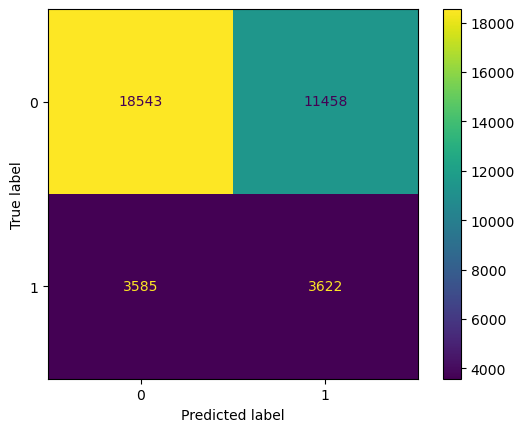

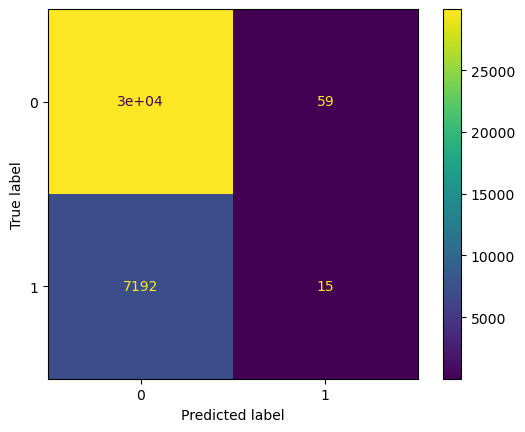

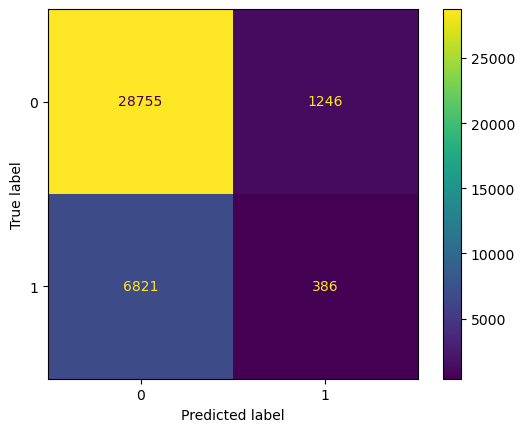

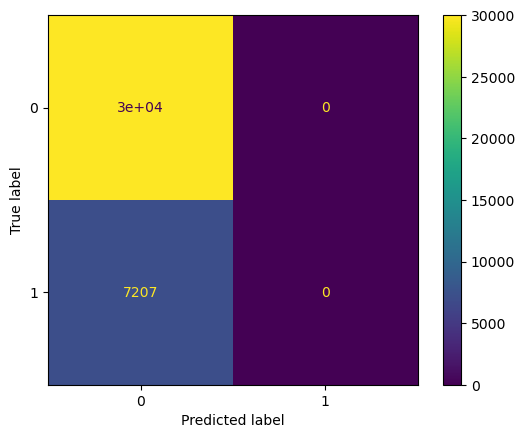

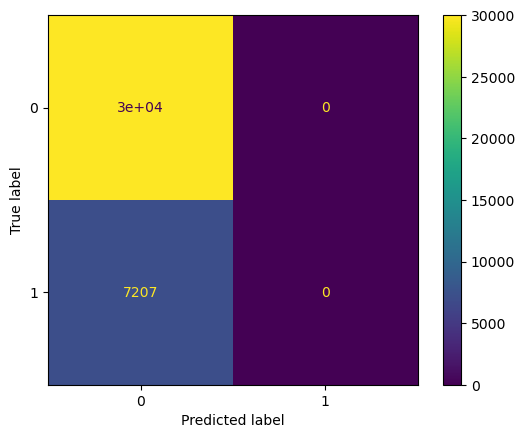

In [12]:
# Compare confusion matrix of all 3 models (use validation set??) and choose the best one?

for item in [ dt_result_bayes, 
              dt_result_gridsearch, 
              knn_result_bayes,
              #knn_result_gridsearch,
              log_result_bayes,
              log_result_gridsearch ]:
    cm = confusion_matrix(y_test, item.y_pred) 
    print_confusion_matrix(cm)
    item.print_results(y_test)
    
